In [1]:
import pandas as pd
import numpy as np
import os
import cv2
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from math import ceil
from tensorflow.keras.models import load_model

c:\Users\Dell\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
Train_data_dir="/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train"
Test_data_dir="/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test"
Val_data_dir="/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation"

In [4]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)

#Data generator
train_data=train_datagen.flow_from_directory(directory=Train_data_dir,
                                             target_size=(128,128),
                                             class_mode='categorical',
                                             batch_size=32)
val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=Val_data_dir,
                                                  target_size=(128,128),
                                                  class_mode='categorical',
                                                  batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=Test_data_dir,
                                                   target_size=(128,128),
                                                   class_mode='categorical',
                                                   batch_size=32)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [4]:
#VGG19 model
model_file = 'MaskDetection2.h5'

if os.path.exists(model_file):
    model=load_model(model_file)
else:    
    vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

    for layer in vgg19.layers:
        layer.trainable = False

    model = Sequential()
    model.add(vgg19)
    model.add(Flatten())
    model.add(Dense(2, activation = "sigmoid"))
    

In [5]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
#Training
train_steps_per_epoch = ceil(len(train_data) / 32)
val_steps_per_epoch = ceil(len(val_generator) / 32)

history = model.fit_generator(generator=train_data,
                              steps_per_epoch=train_steps_per_epoch,
                              epochs=17,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch)

/tmp/ipykernel_28/2597283305.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_data,


Epoch 1/17
10/10 [==============================] - 4s 369ms/step - loss: 0.0775 - accuracy: 0.9688 - val_loss: 0.0596 - val_accuracy: 0.9688
Epoch 2/17
10/10 [==============================] - 3s 333ms/step - loss: 0.0828 - accuracy: 0.9656 - val_loss: 0.0600 - val_accuracy: 1.0000
Epoch 3/17
10/10 [==============================] - 3s 345ms/step - loss: 0.0488 - accuracy: 0.9875 - val_loss: 0.0353 - val_accuracy: 1.0000
Epoch 4/17
10/10 [==============================] - 4s 405ms/step - loss: 0.0696 - accuracy: 0.9781 - val_loss: 0.0636 - val_accuracy: 1.0000
Epoch 5/17
10/10 [==============================] - 3s 342ms/step - loss: 0.0431 - accuracy: 0.9937 - val_loss: 0.0567 - val_accuracy: 1.0000
Epoch 6/17
10/10 [==============================] - 3s 328ms/step - loss: 0.0531 - accuracy: 0.9781 - val_loss: 0.0318 - val_accuracy: 1.0000
Epoch 7/17
10/10 [==============================] - 3s 325ms/step - loss: 0.0640 - accuracy: 0.9937 - val_loss: 0.0226 - val_accuracy: 1.0000
Epoch 

In [34]:
#Evaluation
model.evaluate(test_generator)


31/31 [==============================] - 8s 239ms/step - loss: 0.0474 - accuracy: 0.9879


[0.04737260192632675, 0.9879032373428345]

In [23]:
model.save('MaskDetection2.h5')


In [132]:
def FaceMaskDetector(image_path):
    # Load the pre-trained Haar cascade XML file for face detection
    face_cascade = cv2.CascadeClassifier('/kaggle/input/haar-cascade/haarcascade_frontalface_alt.xml')

    # Load the input image
    image = cv2.imread(image_path)

    # Perform face detection using the Haar cascade
    faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    results={1:'Without Mask',0:'With Mask'}

    # Iterate over the detected faces
    for (x, y, w, h) in faces:
        # Extract the face region of interest 
        face = image[y:y+h, x:x+w]

        face=cv2.resize(face,(128,128))
        normalized=face/255.0
        reshaped=np.reshape(normalized,(1,128,128,3))
        reshaped = np.vstack([reshaped])
        result=model.predict(reshaped)
        
        # Determine the label based on the face mask detection result
        label=np.argmax(result,axis=1)[0]
        
        # Draw the bounding box around the face
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Display the resulting image
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(results[label])
    plt.show()

1/1 [==============================] - 0s 25ms/step


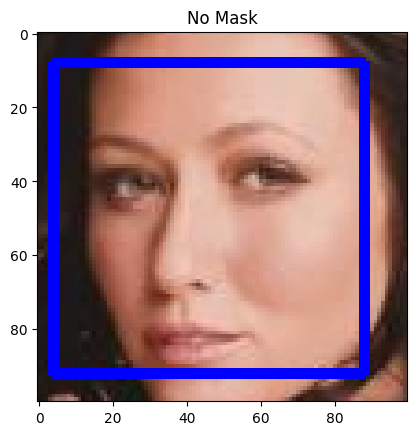

In [133]:
FaceMaskDetector('/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithoutMask/1014.png')

1/1 [==============================] - 0s 25ms/step


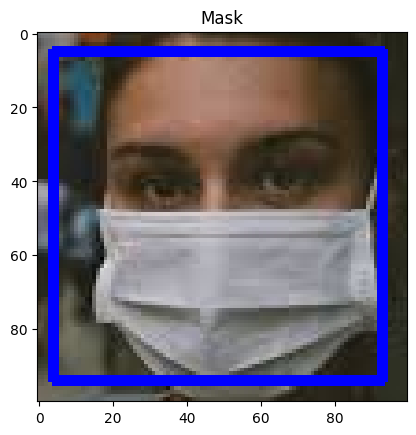

In [141]:
FaceMaskDetector('/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask/153.png')